In [133]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../../')
from SynRBL.rsmi_utils import load_database
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
from SynRBL.SynMCS import FindMissingGraphs
from rdkit import Chem
#bug = load_database('../../Data/MCS/Bug.json.gz')
#bug = load_database('../../Data/MCS/Intersection_MCS_0_50_largest.json.gz')
bug = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')
original = load_database('../../Data/MCS/Original_data_Intersection_MCS_3+_matching_ensemble.json.gz')
msc_df = pd.DataFrame(bug)

              
mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=10, use_findMCS=True)

# 1. Bug Both side missing

In [178]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
from SynRBL.SynCleaning import SMILESStandardizer
from SynRBL.SynExtract import RSMIDecomposer  
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import save_database

reactions = load_database('../../Data/reaction_clean.json.gz')
# decompose into dict of symbols
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=10, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

# compare dict and check balance
comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=10)
unbalance, diff_formula = comp.run_parallel(reactants=react_dict, products=product_dict)

reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})], axis=1).to_dict(orient='records')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 3850 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 

In [220]:
react_dict

[{'C': 27, 'O': 7, 'N': 3, 'H': 37},
 {'N': 4, 'C': 19, 'O': 4, 'S': 2, 'Cl': 2, 'H': 12},
 {'C': 38, 'N': 4, 'O': 6, 'S': 1, 'H': 40},
 {'C': 46, 'N': 8, 'O': 7, 'S': 1, 'Cl': 1, 'F': 2, 'H': 51},
 {'C': 24, 'O': 4, 'N': 5, 'F': 1, 'Cl': 1, 'H': 29},
 {'C': 19, 'N': 6, 'Br': 1, 'O': 2, 'B': 1, 'H': 16},
 {'C': 34, 'O': 5, 'B': 1, 'N': 2, 'Br': 1, 'H': 36},
 {'C': 19, 'O': 5, 'Cl': 2, 'N': 1, 'H': 17},
 {'C': 12, 'O': 4, 'N': 2, 'Br': 1, 'Cl': 1, 'H': 16},
 {'C': 19, 'O': 4, 'P': 1, 'N': 5, 'Br': 1, 'H': 27},
 {'C': 18, 'O': 4, 'N': 2, 'H': 22},
 {'C': 22, 'O': 6, 'N': 3, 'H': 23},
 {'C': 28, 'N': 5, 'O': 9, 'H': 43},
 {'N': 4, 'C': 16, 'O': 1, 'H': 22},
 {'Br': 2, 'C': 13, 'O': 2, 'H': 12},
 {'C': 17, 'O': 1, 'N': 2, 'Cl': 1, 'H': 17},
 {'C': 27, 'O': 2, 'Cl': 1, 'N': 3, 'S': 1, 'H': 22},
 {'F': 4, 'C': 15, 'Br': 1, 'N': 1, 'O': 1, 'H': 12},
 {'C': 8, 'S': 1, 'F': 2, 'N': 1, 'H': 11},
 {'C': 23, 'O': 2, 'N': 4, 'Cl': 2, 'H': 30},
 {'C': 22, 'N': 4, 'F': 1, 'H': 31},
 {'O': 3, 'C': 18,

In [222]:
from joblib import  Parallel, delayed
class process_both_sides:
    def __init__(self, react_dict, product_dict, unbalance, diff_formula):
        self.react_dict = react_dict
        self.product_dict = product_dict
        for key, value in enumerate(self.react_dict):
            if 'Q' not in value:
                self.react_dict[key]['Q'] = 0
        for key, value in enumerate(self.product_dict):
            if 'Q' not in value:
                self.react_dict[key]['Q'] =0
        self.unbalance = unbalance
        self.diff_formula = diff_formula

    @staticmethod
    def enforce_product_side(react_dict, product_dict):
        diff_dict = {}
        for key in react_dict.keys():
            if key in product_dict:
                diff_value = (react_dict[key] - product_dict[key])
                if diff_value != 0:
                    diff_dict[key] = diff_value
            else:
                # Add the count if the key is only in the reactant
                if react_dict[key] != 0:
                    diff_dict[key] = react_dict[key]

        for key in product_dict.keys():
            if key not in react_dict and product_dict[key] != 0:
                diff_dict[key] = product_dict[key]

        return diff_dict


    @staticmethod
    def filter_list_by_indices(data, indices):
        """
        Filter a list, keeping only elements at specified indices.

        Parameters:
        data (list): A list of elements.
        indices (list): A list of indices to filter by.

        Returns:
        list: A new list containing elements from the specified indices.
        """
        # Use list comprehension to filter the list by indices
        filtered_list = [data[i] for i in indices if i < len(data)]

        return filtered_list

    @staticmethod
    def reverse_values_if_negative_except_Q(diff_dict):
        if len(diff_dict) == 2 and 'Q' in diff_dict.keys():
            # Check if any value is less than 0 except for the key 'Q'
            if any(value < 0 for key, value in diff_dict.items() if key != 'Q'):
                # Reverse all values
                return {key: -value for key, value in diff_dict.items()}, 'Reactants'
            else:
                # Return the original dictionary if no modification is needed
                return diff_dict, 'Products'
        else:
            return diff_dict, 'Both'

    def fit(self,):
        both_index = [key for key, value in enumerate(self.unbalance) if value == 'Both']
        print(len(both_index))
        react_dict_both = self.filter_list_by_indices(self.react_dict, both_index)
        print(react_dict_both)
        product_dict_both = self.filter_list_by_indices(self.product_dict, both_index)
        print(product_dict_both)
        diff_dict = Parallel(n_jobs=10, verbose=1)(
            delayed(self.enforce_product_side)(react_dict, product_dict)
            for react_dict, product_dict in zip(react_dict_both, product_dict_both)
        )
        results = [self.reverse_values_if_negative_except_Q(i) for i in diff_dict]
        diff_dict_both, unbalance_both = zip(*results)
        for index, diff_new, unbalance_new in zip(both_index, diff_dict_both, unbalance_both):
            self.diff_formula[index] = diff_new
            self.unbalance[index] = unbalance_new

        return self.diff_formula, self.unbalance


In [277]:
from joblib import Parallel, delayed

class BothSideReact:
    def __init__(self, react_dict, product_dict, unbalance, diff_formula):
        self.react_dict = react_dict
        self.product_dict = product_dict

        # Ensure 'Q' key is present in all dictionaries
        for d in [self.react_dict, self.product_dict]:
            for value in d:
                if 'Q' not in value:
                    value['Q'] = 0

        self.unbalance = unbalance
        self.diff_formula = diff_formula

    @staticmethod
    def enforce_product_side(react_dict, product_dict):
        diff_dict = {}
        # Calculate the difference
        for key, value in react_dict.items():
            diff_value = value - product_dict.get(key, 0)
            if diff_value != 0:
                diff_dict[key] = diff_value
        print(diff_dict)
        # Add keys only in product_dict
        for key, value in product_dict.items():
            if key not in react_dict:
                diff_dict[key] = -value

        return diff_dict

    @staticmethod
    def filter_list_by_indices(data, indices):
        """
        Filter a list, keeping only elements at specified indices.
        """
        return [data[i] for i in indices if i < len(data)]

    @staticmethod
    def reverse_values_if_negative_except_Q(diff_dict):
        if len(diff_dict) == 2 and 'Q' in diff_dict.keys():
            if any(value < 0 for key, value in diff_dict.items() if key != 'Q'):
                return {key: -value for key, value in diff_dict.items()}, 'Reactants'
            else:
                return diff_dict, 'Products'
        else:
            return diff_dict, 'Both'

    def fit(self):
        both_index = [i for i, val in enumerate(self.unbalance) if val == 'Both']
        react_dict_both = self.filter_list_by_indices(self.react_dict, both_index)
        product_dict_both = self.filter_list_by_indices(self.product_dict, both_index)
        print(react_dict_both)
        print(product_dict_both)

        # Process in parallel
        diff_dict = Parallel(n_jobs=10, verbose=1)(
            delayed(self.enforce_product_side)(react, prod)
            for react, prod in zip(react_dict_both, product_dict_both)
        )

        # Post-process the results
        results = [self.reverse_values_if_negative_except_Q(item) for item in diff_dict]
        diff_dict_both, unbalance_both = zip(*results)

        # Update diff_formula and unbalance
        for index, diff_new, unbalance_new in zip(both_index, diff_dict_both, unbalance_both):
            self.diff_formula[index] = diff_new
            self.unbalance[index] = unbalance_new

        return self.diff_formula, self.unbalance


In [284]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
from SynRBL.SynCleaning import SMILESStandardizer
from SynRBL.SynExtract import RSMIDecomposer  
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import save_database

reactions = load_database('../../Data/reaction_clean.json.gz')
# decompose into dict of symbols
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=10, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

# compare dict and check balance
comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=10)
unbalance, diff_formula = comp.run_parallel(reactants=react_dict, products=product_dict)


#both_side = BothSideReact(react_dict, product_dict, unbalance, diff_formula)
#diff_formula, unbalance= both_side.fit()

reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})], axis=1).to_dict(orient='records')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done

In [292]:
check = [i for i in diff_formula if i == {'Q': -1, 'H': 1}]
check_df = [reactions_clean[i] for i, values in enumerate(reactions_clean) if values['Diff_formula'] in check]

In [293]:
check_df

[{'id': 'US05739132',
  'class': 4,
  'reactions': 'CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2C1.[N-]=[N+]=[N-]>>CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(Cc4nnn[nH]4)n3)cc2C1',
  'reactants': 'CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2C1.[N-]=[N+]=[N-]',
  'products': 'CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(Cc4nnn[nH]4)n3)cc2C1',
  'standardized_reactants': nan,
  'standardized_products': nan,
  'Unbalance': 'Both',
  'Diff_formula': {'H': 1, 'Q': -1}},
 {'id': 'US05354759',
  'class': 4,
  'reactions': 'CCSc1nc2c(C)ccnc2n1Cc1ccc(-n2cc(Cl)cc2C#N)cc1.[N-]=[N+]=[N-]>>CCSc1nc2c(C)ccnc2n1Cc1ccc(-n2cc(Cl)cc2-c2nnn[nH]2)cc1',
  'reactants': 'CCSc1nc2c(C)ccnc2n1Cc1ccc(-n2cc(Cl)cc2C#N)cc1.[N-]=[N+]=[N-]',
  'products': 'CCSc1nc2c(C)ccnc2n1Cc1ccc(-n2cc(Cl)cc2-c2nnn[nH]2)cc1',
  'standardized_reactants': nan,
  'standardized_products': nan,
  'Unbalance': 'Both',
  'Diff_formula': {'H': 1, 'Q': -1}},
 {'id': 'US04526896',
  'class': 4,
  'reactions': 'N#CCc1ccc2occ(-c3ccccc3)c2c1.[N-]=[N+]=[N-]>>c

In [283]:


bug = unsolve[646:647]


# decompose into dict of symbols
decompose = RSMIDecomposer(smiles=None, data=bug, reactant_col='reactants', product_col='products', parallel=True, n_jobs=10, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

# compare dict and check balance
comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=10)
unbalance, diff_formula = comp.run_parallel(reactants=react_dict, products=product_dict)




both_side = BothSideReact(react_dict, product_dict, unbalance, diff_formula)
diff_formula, unbalance= both_side.fit()

[]
[]


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


ValueError: not enough values to unpack (expected 2, got 0)

In [276]:
diff_formula

[{'Q': 1, 'H': 1}]

In [282]:
unbalance

['Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Reactants',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 'Both',
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Reactants',
 'Products',
 'Products',
 'Both',
 'Products

In [294]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
from SynRBL.SynCleaning import SMILESStandardizer
from SynRBL.SynExtract import RSMIDecomposer  
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import save_database

reactions = load_database('../../Data/reaction_clean.json.gz')
# decompose into dict of symbols
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=10, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

# compare dict and check balance
comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=10)
unbalance, diff_formula = comp.run_parallel(reactants=react_dict, products=product_dict)


both_side = BothSideReact(react_dict, product_dict, unbalance, diff_formula)
diff_formula, unbalance= both_side.fit()

reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})], axis=1).to_dict(orient='records')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done

[{'C': 11, 'N': 1, 'O': 2, 'H': 15, 'Q': 0}, {'C': 21, 'N': 2, 'F': 3, 'O': 2, 'H': 17, 'Q': 0}, {'C': 14, 'O': 3, 'N': 4, 'H': 16, 'Q': 0}, {'C': 17, 'O': 5, 'F': 1, 'H': 15, 'Q': 0}, {'C': 15, 'O': 4, 'N': 3, 'H': 13, 'Q': 0}, {'C': 25, 'O': 3, 'N': 2, 'H': 32, 'Q': 0}, {'O': 1, 'C': 23, 'N': 1, 'F': 1, 'Mg': 1, 'H': 27, 'Q': 1}, {'C': 14, 'O': 1, 'N': 1, 'Br': 1, 'H': 12, 'Q': 0}, {'C': 15, 'O': 4, 'N': 2, 'H': 20, 'Q': 0}, {'C': 19, 'S': 1, 'O': 3, 'N': 7, 'H': 22, 'Q': -1}, {'C': 26, 'N': 4, 'O': 5, 'Cl': 1, 'H': 29, 'Q': 0}, {'C': 19, 'N': 5, 'Cl': 1, 'O': 1, 'H': 18, 'Q': 0}, {'C': 9, 'N': 1, 'S': 1, 'O': 4, 'H': 11, 'Q': 0}, {'C': 13, 'O': 4, 'N': 2, 'H': 18, 'Q': 0}, {'C': 8, 'N': 2, 'O': 2, 'Cl': 1, 'H': 9, 'Q': 0}, {'C': 19, 'O': 6, 'N': 4, 'F': 1, 'H': 23, 'Q': 0}, {'C': 15, 'N': 5, 'O': 3, 'H': 13, 'Q': 0}, {'C': 12, 'O': 4, 'H': 12, 'Q': 0}, {'C': 8, 'O': 4, 'N': 1, 'Br': 1, 'H': 6, 'Q': 0}, {'Br': 1, 'C': 29, 'O': 2, 'F': 2, 'N': 1, 'H': 32, 'Q': 0}, {'O': 1, 'C': 14, 'N

/tmp/ipykernel_2134929/1254261435.py:20: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),


In [295]:

# Filter data based on specified criteria
no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side:', len(no_C_reactions))

un_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=1, max_count=1000)
print('Number of Carbon Reactions Unbalanced in one side:', len(un_C_reactions))

both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                                    formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Both sides Unbalanced Reactions:', len(both_side_reactions))

balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Balanced Reactions:', len(balance_reactions))

Number of Non-Carbon Reactions Unbalanced in one side: 32280
Number of Carbon Reactions Unbalanced in one side: 13752
Number of Both sides Unbalanced Reactions: 2908
Number of Balanced Reactions: 1076


In [296]:
# Configure RDKit logging
from rdkit import  RDLogger
from rdkit import Chem
import rdkit
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

rules = load_database('../../Data/Rules/rules_manager.json.gz')

# Initialize SyntheticRuleImputer and perform parallel imputation
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')
expected_result = imp.parallel_impute(no_C_reactions)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)
print('Solved:', len(solve))
print('Unsolved in rules based method:', len(unsolve))

# Combine all unsolved cases
#unsolve = un_C_reactions + both_side_reactions + unsolve
print('Total unsolved:', len(unsolve))

# Save solved and unsolved reactions
#save_database(solve,  '../../Data/Solved_reactions.json.gz')
#save_database(unsolve,  '../../Data/Unsolved_reactions.json.gz')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 6122 tasks      | elapsed:    0.5s


Solved: 30434
Unsolved in rules based method: 1846
Total unsolved: 1846


[Parallel(n_jobs=-2)]: Done 32280 out of 32280 | elapsed:    1.7s finished


In [300]:
pd.DataFrame(solve)[pd.DataFrame(solve)['id']=='US05739132']

,id,class,reactions,reactants,products,standardized_reactants,standardized_products,Unbalance,Diff_formula,new_reaction
176,US05739132,4,CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2...,CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2...,CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(Cc4nnn[nH]4...,NaN,NaN,Reactants,"{'H': 1, 'Q': 1}",CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2...


In [281]:
pd.DataFrame(unsolve)['Diff_formula'].value_counts()

Diff_formula
{'O': 1, 'Q': 0}             1795
{'O': 1, 'H': 1, 'Q': 1}       40
{'Br': 2, 'O': 1, 'Q': 0}       6
{'Cl': 1, 'Q': 1}               4
{'N': 1, 'H': 1, 'Q': 0}        1
Name: count, dtype: int64

In [242]:
pd.DataFrame(unsolve)[pd.DataFrame(unsolve)['Diff_formula'] == {'Q': -1, 'H': 1} ]

,id,class,reactions,reactants,products,standardized_reactants,standardized_products,Unbalance,Diff_formula
646,US08383643B2,4,N#Cc1nnc(Br)s1.[N-]=[N+]=[N-]>>Brc1nnc(-c2nnn[...,N#Cc1nnc(Br)s1.[N-]=[N+]=[N-],Brc1nnc(-c2nnn[nH]2)s1,NaN,NaN,Products,"{'Q': -1, 'H': 1}"


In [267]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
def smiles_to_molecular_formula(smiles: str) -> str:
    """
    Convert a SMILES string to a molecular formula.

    Args:
        smiles (str): The SMILES string of the molecule.

    Returns:
        str: The molecular formula of the molecule.
    """
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        formula = rdMolDescriptors.CalcMolFormula(molecule)
        return formula

In [268]:
smiles_to_molecular_formula('N#Cc1nnc(Br)s1.[N-]=[N+]=[N-]')

'C3BrN6S-'

In [269]:
smiles_to_molecular_formula('Brc1nnc(-c2nnn[nH]2)s1')

'C3HBrN6S'

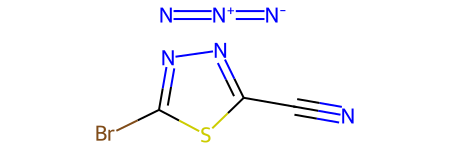

In [244]:
Chem.MolFromSmiles('N#Cc1nnc(Br)s1.[N-]=[N+]=[N-]')

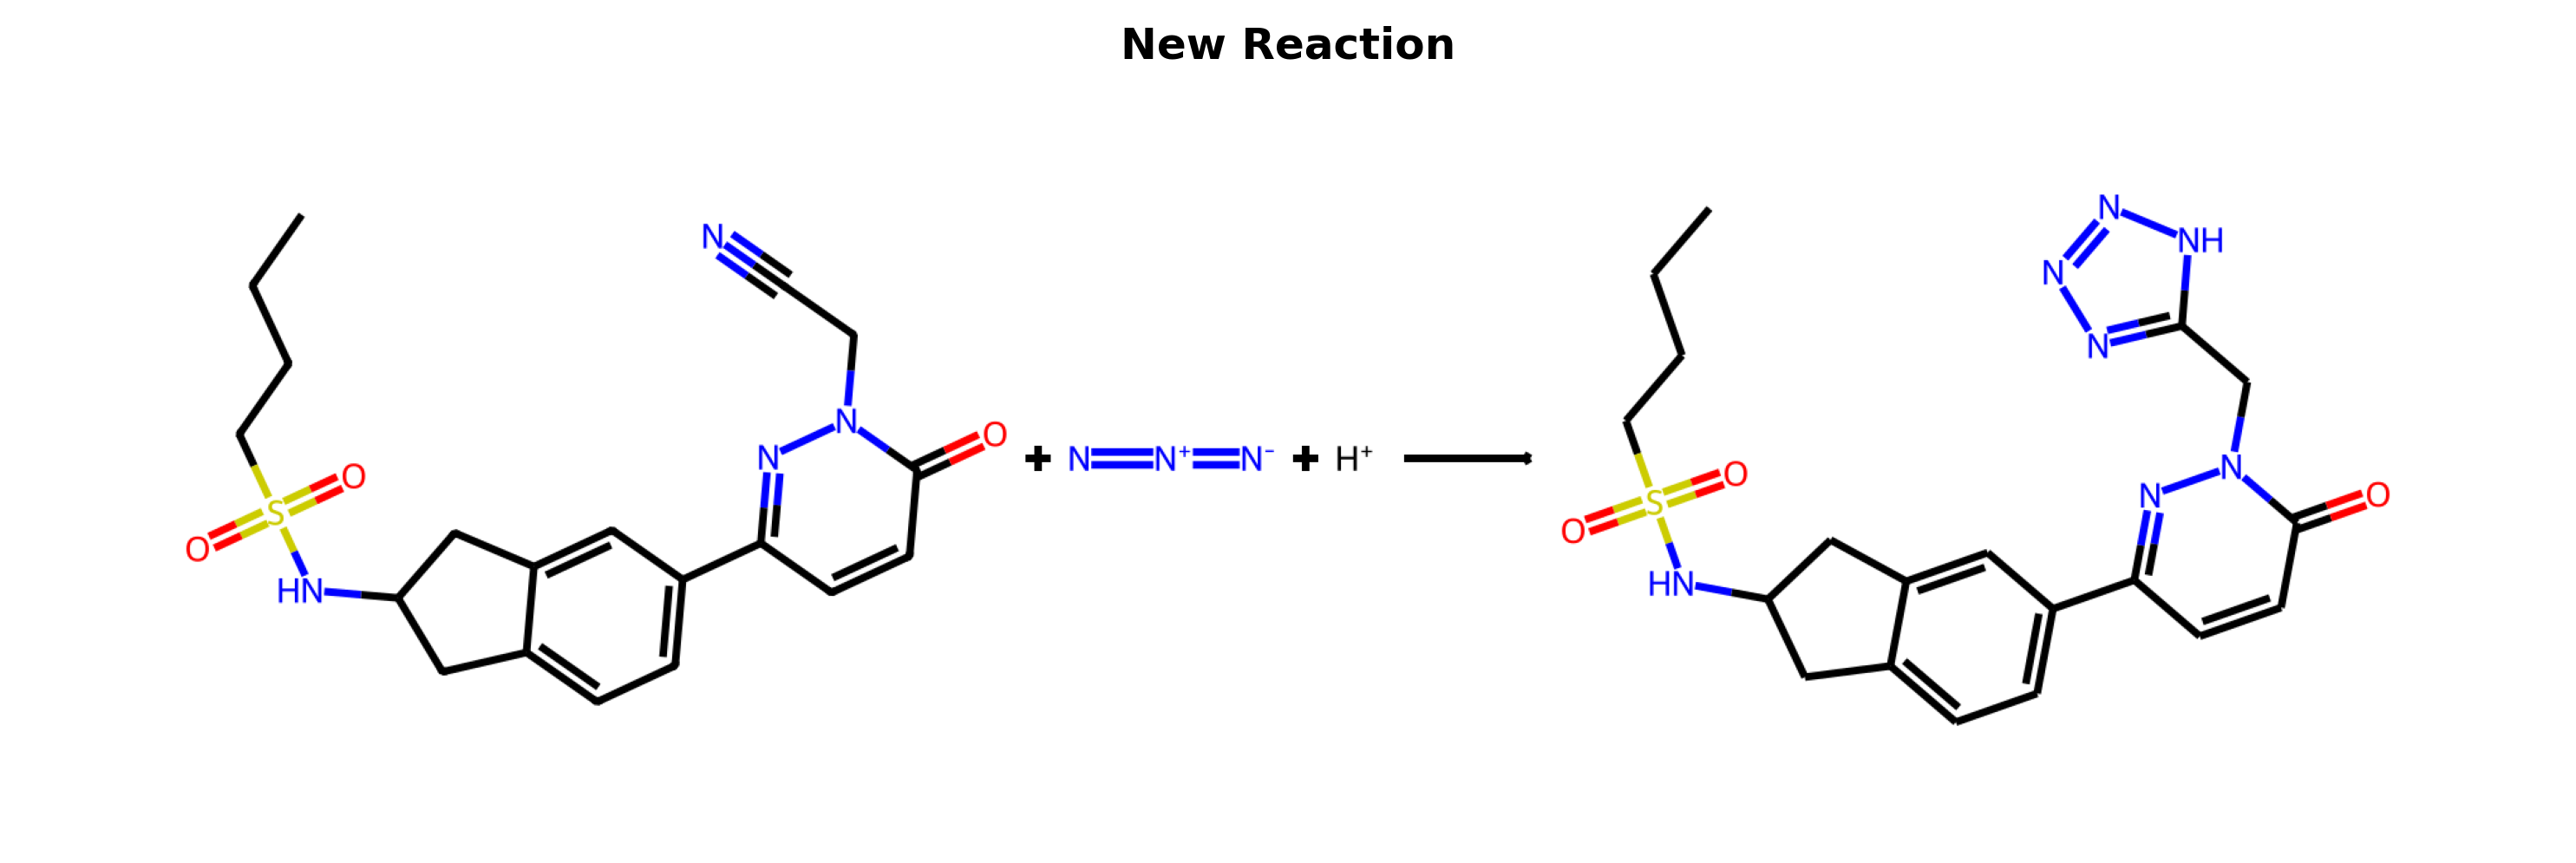

In [301]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(solve[176], 'reactions', 'new_reaction', show_atom_numbers=False, compare= False, savefig=False, pathname = None, dpi=300)

In [233]:
unsolve[1333]

{'id': 'US20030096856A1',
 'class': 9,
 'reactions': 'COc1ccc(S(=O)(=O)Cl)cc1[N+](=O)[O-]>>COc1ccc(S(=O)[O-])cc1[N+](=O)[O-]',
 'reactants': 'COc1ccc(S(=O)(=O)Cl)cc1[N+](=O)[O-]',
 'products': 'COc1ccc(S(=O)[O-])cc1[N+](=O)[O-]',
 'standardized_reactants': nan,
 'standardized_products': nan,
 'Unbalance': 'Products',
 'Diff_formula': {'Cl': 1, 'Q': 1}}

In [214]:
pd.DataFrame(both_side_reactions)['Diff_formula'].value_counts()

Diff_formula
{'O': 2, 'H': 2}                    1591
{'O': 1, 'H': 2}                     573
{'Mg': 1, 'H': 1, 'Q': 1}            219
{'N': 2, 'H': 2}                     168
{'Cl': 1, 'H': 1}                    134
{'Br': 1, 'H': 1}                     87
{'H': 1, 'Q': -1}                     80
{'C': 2, 'O': 1, 'F': 3, 'H': 1}      72
{'Br': 1, 'Q': 1}                     49
{'I': 1, 'Q': 1}                      26
{'Cl': 1, 'Q': 1}                     21
{'C': 5, 'O': 2, 'H': 7, 'Q': 1}      19
{'I': 1, 'H': 1}                      17
{'F': 1, 'H': 1}                      14
{'O': 2, 'Cl': 1, 'H': 1}             10
{'Cl': 1, 'Q': -1}                     4
{'Mg': 1, 'Br': 1, 'H': 1}             3
{'C': 4, 'F': 7, 'O': 1, 'H': 1}       1
Name: count, dtype: int64

In [195]:
test = process_both_sides(react_dict, product_dict, unbalance, diff_formula)
diff_formula, unbalance= test.fit()

3088
[{'C': 11, 'N': 1, 'O': 2, 'H': 15}, {'C': 21, 'N': 2, 'F': 3, 'O': 2, 'H': 17}, {'C': 14, 'O': 3, 'N': 4, 'H': 16}, {'C': 17, 'O': 5, 'F': 1, 'H': 15}, {'C': 15, 'O': 4, 'N': 3, 'H': 13}, {'C': 25, 'O': 3, 'N': 2, 'H': 32}, {'O': 1, 'C': 23, 'N': 1, 'F': 1, 'Mg': 1, 'H': 27, 'Q': 1}, {'C': 14, 'O': 1, 'N': 1, 'Br': 1, 'H': 12}, {'C': 15, 'O': 4, 'N': 2, 'H': 20}, {'C': 19, 'S': 1, 'O': 3, 'N': 7, 'H': 22, 'Q': -1}, {'C': 26, 'N': 4, 'O': 5, 'Cl': 1, 'H': 29}, {'C': 19, 'N': 5, 'Cl': 1, 'O': 1, 'H': 18}, {'C': 9, 'N': 1, 'S': 1, 'O': 4, 'H': 11}, {'C': 13, 'O': 4, 'N': 2, 'H': 18}, {'C': 8, 'N': 2, 'O': 2, 'Cl': 1, 'H': 9}, {'C': 19, 'O': 6, 'N': 4, 'F': 1, 'H': 23}, {'C': 15, 'N': 5, 'O': 3, 'H': 13}, {'C': 12, 'O': 4, 'H': 12}, {'C': 8, 'O': 4, 'N': 1, 'Br': 1, 'H': 6}, {'Br': 1, 'C': 29, 'O': 2, 'F': 2, 'N': 1, 'H': 32}, {'O': 1, 'C': 14, 'N': 1, 'Cl': 2, 'H': 11}, {'O': 2, 'C': 10, 'Cl': 1, 'H': 9}, {'C': 21, 'S': 1, 'N': 8, 'Cl': 1, 'H': 18, 'Q': -1}, {'C': 18, 'S': 1, 'O': 4

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 2660 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 3088 out of 3088 | elapsed:    0.6s finished


In [177]:
unbalance

'Both'

In [196]:
both = [i for i in unbalance if i == 'Both']
len(both)

2908

In [167]:
unbalance

'Both'

In [210]:
from SynRBL.rsmi_utils import save_database, load_database, filter_data, extract_results_by_key
from SynRBL.SynRuleImpute import SyntheticRuleImputer

rules = load_database('../../Data/Rules/rules_manager.json.gz')
reactions_clean = load_database('../../Data/reaction_clean.json.gz')

# Filter data based on specified criteria
no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side:', len(no_C_reactions))

un_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=1, max_count=1000)
print('Number of Carbon Reactions Unbalanced in one side:', len(un_C_reactions))

both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                                    formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Both sides Unbalanced Reactions:', len(both_side_reactions))

balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Balanced Reactions:', len(balance_reactions))

Number of Non-Carbon Reactions Unbalanced in one side: 32100
Number of Carbon Reactions Unbalanced in one side: 13752
Number of Both sides Unbalanced Reactions: 3088
Number of Balanced Reactions: 1076


In [162]:
test = process_both_sides(react_dict, product_dict, unbalance, diff_formula)
results= test.fit()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    0.3s finished


In [163]:
results

[({'C': 8, 'O': 2, 'H': 6}, 'Both'),
 ({'O': 1, 'H': 2}, 'Both'),
 ({'O': 1}, 'Both'),
 ({'O': 1}, 'Both'),
 ({'Cl': 1, 'H': 1}, 'Both'),
 ({'Br': 1, 'O': 2, 'B': 1, 'H': 2}, 'Both'),
 ({'C': 6, 'O': 2, 'B': 1, 'Br': 1, 'H': 12}, 'Both'),
 ({'H': -2}, 'Both'),
 ({'O': 1, 'H': 2}, 'Both'),
 ({'Br': 1, 'H': 1}, 'Both'),
 ({'C': 4, 'H': 8}, 'Both'),
 ({'C': 8, 'O': 1, 'H': 8}, 'Both'),
 ({'O': 1, 'H': 2}, 'Both'),
 ({'O': 1}, 'Both'),
 ({'Br': 1, 'H': 1}, 'Both'),
 ({'C': 1, 'H': 2}, 'Both'),
 ({'Cl': 1, 'H': 1}, 'Both'),
 ({'F': 1, 'H': 1}, 'Both'),
 ({'F': 1, 'H': 1}, 'Both'),
 ({'Cl': 1, 'H': 1}, 'Both'),
 ({'C': 7, 'H': 6}, 'Both'),
 ({'O': 1, 'H': 2}, 'Both'),
 ({'Br': 1, 'Q': -1}, 'Products'),
 ({'Br': 1, 'H': 1}, 'Both'),
 ({'C': 3, 'Si': 1, 'H': 8}, 'Both'),
 ({'Cl': 1, 'H': 1}, 'Both'),
 ({}, 'Both'),
 ({'Br': 1, 'H': 1}, 'Both'),
 ({'O': 1, 'H': 2}, 'Both'),
 ({'C': 1, 'H': 2}, 'Both'),
 ({'O': 1, 'H': 2}, 'Both'),
 ({}, 'Both'),
 ({'C': 18, 'O': 1, 'P': 1, 'H': 15}, 'Both'),
 (

In [156]:
diff_dict

[]

In [136]:
unbalance.get('Both')

AttributeError: 'list' object has no attribute 'get'

In [140]:
both_index = [key for key, value in enumerate(unbalance) if value == 'Both']

In [141]:
len(both_index)

3088

In [144]:
react_dict[both_index]

TypeError: list indices must be integers or slices, not list

In [142]:
both_index

[51,
 76,
 93,
 148,
 150,
 163,
 206,
 235,
 270,
 294,
 333,
 345,
 366,
 410,
 411,
 437,
 438,
 453,
 462,
 484,
 486,
 488,
 525,
 526,
 540,
 555,
 558,
 583,
 614,
 625,
 627,
 699,
 700,
 703,
 713,
 721,
 730,
 761,
 806,
 814,
 818,
 839,
 848,
 865,
 866,
 909,
 911,
 929,
 935,
 942,
 946,
 977,
 979,
 1002,
 1020,
 1024,
 1036,
 1039,
 1042,
 1082,
 1088,
 1095,
 1097,
 1146,
 1148,
 1173,
 1175,
 1205,
 1213,
 1239,
 1240,
 1241,
 1246,
 1250,
 1267,
 1287,
 1339,
 1351,
 1368,
 1385,
 1386,
 1387,
 1421,
 1456,
 1469,
 1475,
 1481,
 1507,
 1529,
 1537,
 1549,
 1552,
 1591,
 1629,
 1653,
 1677,
 1690,
 1700,
 1702,
 1731,
 1741,
 1743,
 1758,
 1761,
 1762,
 1763,
 1771,
 1776,
 1796,
 1850,
 1852,
 1882,
 1885,
 1886,
 1904,
 1929,
 1932,
 1949,
 1970,
 1975,
 2003,
 2011,
 2022,
 2042,
 2071,
 2094,
 2095,
 2117,
 2123,
 2179,
 2208,
 2217,
 2240,
 2251,
 2277,
 2281,
 2283,
 2312,
 2318,
 2334,
 2340,
 2343,
 2345,
 2356,
 2391,
 2454,
 2471,
 2481,
 2507,
 2532,
 2540,

# 2. Bug no logic in reduction agent

In [52]:
from SynRBL.rsmi_utils import load_database, save_database
original_data = load_database(f'../../Data/MCS/Original_data_Intersection_MCS_0_50_largest.json.gz')
len(original_data)

1223

In [53]:
test = load_database(f'../../Data/MCS/Final_Graph_macth_under2-.json.gz')
len(test)

1223

In [55]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../../')
from SynRBL.rsmi_utils import load_database, save_database

In [56]:
unsolved = load_database('../../Data/Unsolved_reactions.json.gz')

Number of Non-Carbon Reactions Unbalanced in one side: 32100
Number of Carbon Reactions Unbalanced in one side: 13752
Number of Both sides Unbalanced Reactions: 3088
Number of Balanced Reactions: 1076


In [69]:
both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                                    formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
both_df = pd.DataFrame(both_side_reactions)
both_df['Diff_formula'].value_counts()

Diff_formula
{'O': 2, 'H': 2}              1591
{'O': 1, 'H': 2}               573
{'Mg': 1, 'H': 1, 'Q': 1}      219
{'N': 2, 'H': 2}               168
{'Cl': 1, 'H': 1}              134
{'Br': 1, 'H': 1}               87
{'H': 1, 'Q': -1}               80
{'Br': 1, 'Q': 1}               49
{'I': 1, 'Q': 1}                26
{'Cl': 1, 'Q': 1}               21
{'I': 1, 'H': 1}                17
{'F': 1, 'H': 1}                14
{'O': 2, 'Cl': 1, 'H': 1}       10
{'Cl': 1, 'Q': -1}               4
{'Mg': 1, 'Br': 1, 'H': 1}       3
Name: count, dtype: int64

In [72]:
both_df

,id,class,reactions,reactants,products,standardized_reactants,standardized_products,Unbalance,Diff_formula
0,US06492393B1,7,Cc1ccc(C(C)(C)C)cc1[N+](=O)[O-]>>Cc1ccc(C(C)(C...,Cc1ccc(C(C)(C)C)cc1[N+](=O)[O-],Cc1ccc(C(C)(C)C)cc1N,NaN,NaN,Both,"{'O': 2, 'H': 2}"
1,US06329405B1,7,CC(NC(c1ccc(F)cc1)c1cccc([N+](=O)[O-])c1)c1ccc...,CC(NC(c1ccc(F)cc1)c1cccc([N+](=O)[O-])c1)c1ccc...,CC(NC(c1ccc(F)cc1)c1cccc(N)c1)c1ccc(F)c(F)c1,NaN,NaN,Both,"{'O': 2, 'H': 2}"
2,US03987160,7,CCCOc1ccc(C)cc1-c1nc(N)c(N=O)c(=O)[nH]1>>CCCOc...,CCCOc1ccc(C)cc1-c1nc(N)c(N=O)c(=O)[nH]1,CCCOc1ccc(C)cc1-c1nc(N)c(N)c(=O)[nH]1,NaN,NaN,Both,"{'O': 1, 'H': 2}"
3,US06818774B2,7,COC(=O)Cc1cc(OCc2ccc(F)cc2)ccc1C(=O)O>>COC(=O)...,COC(=O)Cc1cc(OCc2ccc(F)cc2)ccc1C(=O)O,COC(=O)Cc1cc(OCc2ccc(F)cc2)ccc1CO,NaN,NaN,Both,"{'O': 1, 'H': 2}"
4,US05010077,7,CCOC(=O)c1ncc2[nH]c3ccc([N+](=O)[O-])cc3c2c1C>...,CCOC(=O)c1ncc2[nH]c3ccc([N+](=O)[O-])cc3c2c1C,CCOC(=O)c1ncc2[nH]c3ccc(N)cc3c2c1C,NaN,NaN,Both,"{'O': 2, 'H': 2}"
...,...,...,...,...,...,...,...,...,...
2991,US05599832,9,Cn1c(I)cc2cc(Cl)ccc21>>Cn1ccc2cc(Cl)ccc21,Cn1c(I)cc2cc(Cl)ccc21,Cn1ccc2cc(Cl)ccc21,NaN,NaN,Both,"{'I': 1, 'H': 1}"
2992,US04851418,9,[N-]=[N+]=N[C@H]1CCN(C(=O)OCc2ccccc2)C1>>N[C@H...,[N-]=[N+]=N[C@H]1CCN(C(=O)OCc2ccccc2)C1,N[C@H]1CCN(C(=O)OCc2ccccc2)C1,NaN,NaN,Both,"{'N': 2, 'H': 2}"
2993,US06265432B1,9,O=C(O)CCC(=NO)c1ccc(-c2ccc(Cl)cc2)c(F)c1>>O=C(...,O=C(O)CCC(=NO)c1ccc(-c2ccc(Cl)cc2)c(F)c1,O=C(O)CCC(=NO)c1ccc(-c2ccccc2)c(F)c1,NaN,NaN,Both,"{'Cl': 1, 'H': 1}"
2994,US20130303532A1,9,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1,NaN,NaN,Both,"{'Br': 1, 'H': 1}"


In [98]:
both_df[both_df['Diff_formula'] == {'H': 1, 'Q': -1}]['reactions']

9       CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2...
22      CCSc1nc2c(C)ccnc2n1Cc1ccc(-n2cc(Cl)cc2C#N)cc1....
33      N#CCc1ccc2occ(-c3ccccc3)c2c1.[N-]=[N+]=[N-]>>c...
101     N#Cc1cc2cc(-c3ccc(C(F)(F)F)cn3)ccc2n1-c1ccc(OC...
194     N#CCc1ccc(OCC2CCCCC2)cc1.[N-]=[N+]=[N-]>>c1cc(...
                              ...                        
2905    N#Cc1ccccc1NC(=O)c1ccc(Oc2ccc3ccccc3c2)cc1.[N-...
2908    CC(C)(C)OC(=O)N1CCC[C@H]1C#N.[N-]=[N+]=[N-]>>C...
2912    N#Cc1cc(-c2ccccc2)ccc1NC(=O)c1cc(C(F)(F)F)cc(C...
2949    CCCCC(=O)c1c(-c2ccc3c(Br)c(OCC#N)ccc3c2)sc2ccc...
2955    Cc1nc2c3ccccc3ccn2c1CC#N.[N-]=[N+]=[N-]>>Cc1nc...
Name: reactions, Length: 80, dtype: object

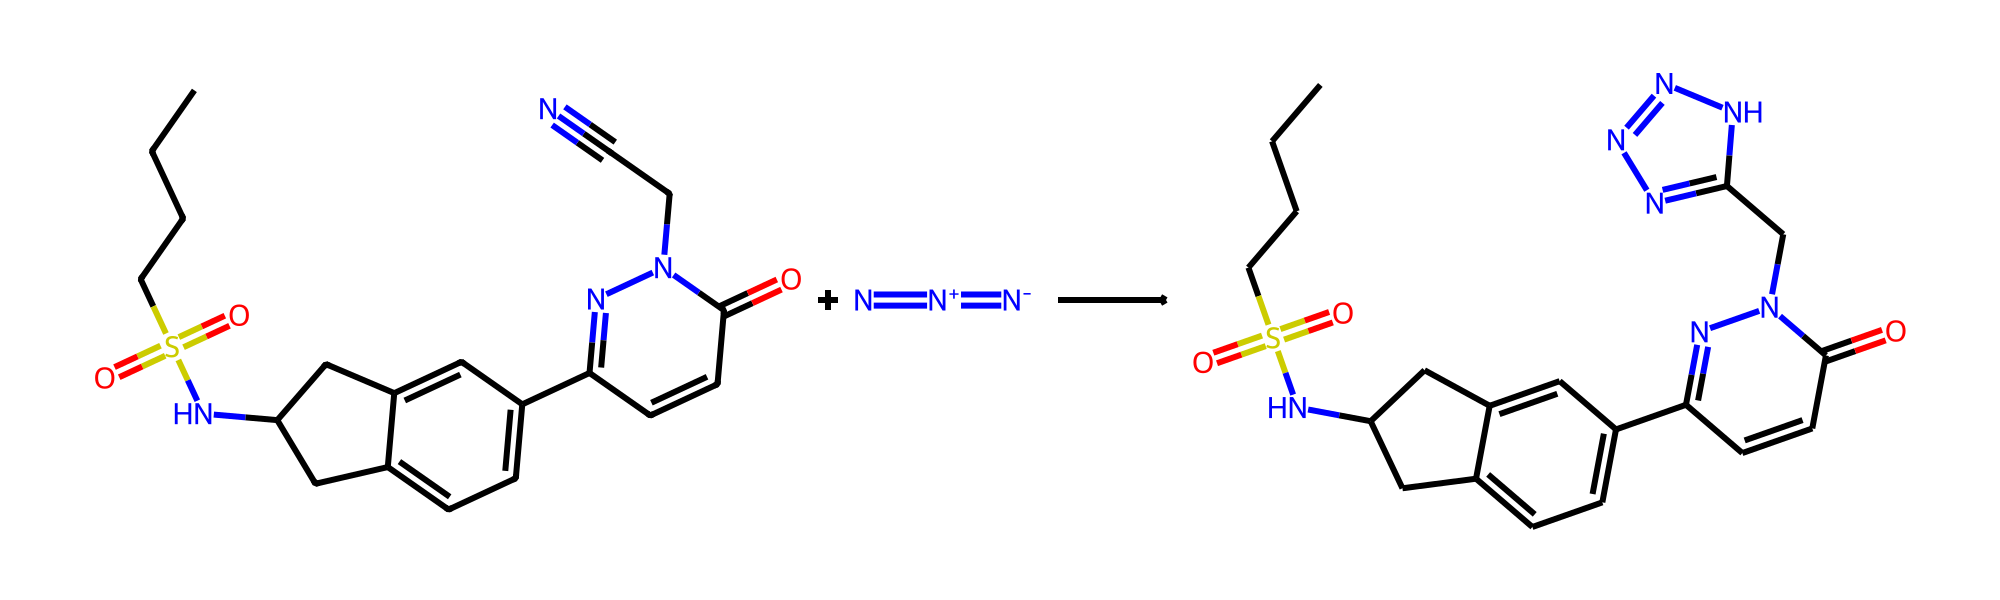

In [99]:
from SynRBL.SynVis.reaction_visualizer  import ReactionVisualizer
vis = ReactionVisualizer()
vis.visualize_reaction(both_df[both_df['Diff_formula'] == {'H': 1, 'Q': -1}]['reactions'][9])

In [57]:
pd.DataFrame(unsolved)

,id,class,reactions,reactants,products,standardized_reactants,standardized_products,Unbalance,Diff_formula
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,COC(=O)C(CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)c...,COC(=O)C(CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,Products,"{'C': 8, 'O': 2, 'H': 6}"
1,US20110224204A1,3,CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#...,CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#...,N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)c...,CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#...,N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)c...,Products,"{'C': 6, 'O': 2, 'B': 1, 'Br': 1, 'H': 12}"
2,US20110263607A1,6,CC(C)(C)OC(=O)CONC(=O)NCc1cccc2ccccc12>>O=C(O)...,CC(C)(C)OC(=O)CONC(=O)NCc1cccc2ccccc12,O=C(O)CONC(=O)NCc1cccc2ccccc12,NaN,NaN,Products,"{'C': 4, 'H': 8}"
3,US06372735B1,6,CCOC(=O)c1nnn(Cc2ccc(OC)cc2)c1C(=O)c1ccc(OC)c(...,CCOC(=O)c1nnn(Cc2ccc(OC)cc2)c1C(=O)c1ccc(OC)c(...,CCOC(=O)c1nn[nH]c1C(=O)c1ccc(OC)c(OC)c1,NaN,NaN,Products,"{'C': 8, 'O': 1, 'H': 8}"
4,US20070225349A1,6,COc1ccc(-c2nn(C(C)C)c3c(Cl)cccc23)cc1>>CC(C)n1...,COc1ccc(-c2nn(C(C)C)c3c(Cl)cccc23)cc1,CC(C)n1nc(-c2ccc(O)cc2)c2cccc(Cl)c21,NaN,NaN,Products,"{'C': 1, 'H': 2}"
...,...,...,...,...,...,...,...,...,...
18677,US20050171131A1,1,CS(=O)(=O)c1ccc(C=O)cc1.Nc1ccc(-c2c(N)nc(N)nc2...,CS(=O)(=O)c1ccc(C=O)cc1.Nc1ccc(-c2c(N)nc(N)nc2...,CS(=O)(=O)c1ccc(CNc2ccc(-c3c(N)nc(N)nc3C3CCCC3...,NaN,NaN,Products,"{'O': 1, 'Q': 0}"
18678,US04027040,9,Cc1c(C(=O)O)cccc1C(=O)c1ccc(Cl)cc1>>Cc1c(C=O)c...,Cc1c(C(=O)O)cccc1C(=O)c1ccc(Cl)cc1,Cc1c(C=O)cccc1C(=O)c1ccc(Cl)cc1,NaN,NaN,Products,"{'O': 1, 'Q': 0}"
18679,US20040209921A1,1,Cc1cc(Cl)cnc1CNCCCCN(C)C(=O)OC(C)(C)C.O=Cc1ncc...,Cc1cc(Cl)cnc1CNCCCCN(C)C(=O)OC(C)(C)C.O=Cc1ncc...,Cc1cc(Cl)cnc1CN(CCCCN(C)C(=O)OC(C)(C)C)Cc1nccc...,NaN,NaN,Products,"{'O': 1, 'Q': 0}"
18680,US07473703B2,9,COCCn1cccc1C(C)(O)c1ccc(N(C)S(=O)(=O)c2ccccc2)...,COCCn1cccc1C(C)(O)c1ccc(N(C)S(=O)(=O)c2ccccc2)cc1,COCCn1cccc1C(C)c1ccc(N(C)S(=O)(=O)c2ccccc2)cc1,NaN,NaN,Products,"{'O': 1, 'Q': 0}"


In [88]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
from SynRBL.SynCleaning import SMILESStandardizer
from SynRBL.SynExtract import RSMIDecomposer  
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import save_database

reactions = load_database('../../Data/reaction_clean.json.gz')
# decompose into dict of symbols
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=10, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

# compare dict and check balance
comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=10)
unbalance, diff_formula = comp.run_parallel(reactants=react_dict, products=product_dict)

reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})], axis=1).to_dict(orient='records')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 5120 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 

In [91]:
react_dict_both, product_dict_both = [], []
for key, values in enumerate(unbalance):
    if values == 'Both':
        react_dict_both.append(react_dict[key])
        product_dict_both.append(product_dict[key])

In [114]:
react_dict = react_dict_both[9]
product_dict = product_dict_both[9]

In [117]:
react_dict

{'C': 19, 'S': 1, 'O': 3, 'N': 7, 'H': 22, 'Q': -1}

In [118]:
product_dict

{'C': 19, 'S': 1, 'O': 3, 'N': 7, 'H': 23}

In [ ]:
class process_both_sides:
    def __init__(self, react_dict, product_dict, unbalance, diff_formula):
        self.react_dict = react_dict
        self.product_dict = product_dict
        self.unbalance = unbalance
        self.diff_formula = diff_formula
    
    @staticmethod
    def reverse_values_if_negative_except_Q(input_dict):
        if len(input_dict) == 2 and 'Q' in input_dict.keys():
            # Check if any value is less than 0 except for the key 'Q'
            if any(value < 0 for key, value in input_dict.items() if key != 'Q'):
                # Reverse all values
                return {key: -value for key, value in input_dict.items()}, 'Reactants'
            else:
                # Return the original dictionary if no modification is needed
                return input_dict, 'Products'
        else:
            return input_dict, 'Both'

    @staticmethod
    def enforce_product_side(react_dict, product_dict)
        diff_dict = {}
        for key in react_dict.keys():
            if key in product_dict:
                #print(product_dict_both[61][key] - react_dict_both[61][key])
                diff_value = (react_dict[key] - product_dict[key])
                if diff_value != 0:
                    diff_dict[key] = diff_value
            else:
                # Add the count if the key is only in the reactant
                if react_dict[key] != 0:
                    diff_dict[key] = react_dict[key]

        for key in product_dict.keys():
            if key not in react_dict and product_dict[key] != 0:
                diff_dict[key] = product_dict[key]

    def fit(self,):
        pass

In [119]:
diff_dict = {}
for key in react_dict.keys():
    if key in product_dict:
        #print(product_dict_both[61][key] - react_dict_both[61][key])
        diff_value = (react_dict[key] - product_dict[key])
        if diff_value != 0:
            diff_dict[key] = diff_value
    else:
        # Add the count if the key is only in the reactant
        if react_dict[key] != 0:
            diff_dict[key] = react_dict[key]

for key in product_dict.keys():
    if key not in react_dict and product_dict[key] != 0:
        diff_dict[key] = product_dict[key]

In [130]:
'Q' in diff_dict.keys()

True

In [132]:
def reverse_values_if_negative_except_Q(input_dict):
    if len(input_dict) == 2 and 'Q' in input_dict.keys():
        # Check if any value is less than 0 except for the key 'Q'
        if any(value < 0 for key, value in input_dict.items() if key != 'Q'):
            # Reverse all values
            return {key: -value for key, value in input_dict.items()}, 'Reactants'
        else:
            # Return the original dictionary if no modification is needed
            return input_dict, 'Products'
    else:
        return input_dict, 'Both'

# Example usage
input_dict = {'H': -1, 'Q': -1}
result_dict = reverse_values_if_negative_except_Q(input_dict)
print(result_dict)


({'H': 1, 'Q': 1}, 'Reactants')


In [123]:
for key in diff_dict:
    if diff_dict[key] < 0 with key != 'Q':
        diff_dict[key] = -diff_dict[key]



SyntaxError: invalid syntax (2145103311.py, line 2)

In [120]:
diff_dict

{'H': -1, 'Q': -1}

In [ ]:
diff_dict = {}

# Calculate differences for keys present in both dictionaries
for key in reactant.keys():
    if key in product:
        diff_value = abs(reactant[key] - product[key])
        if diff_value != 0:
            diff_dict[key] = diff_value
    else:
        # Add the count if the key is only in the reactant
        if reactant[key] != 0:
            diff_dict[key] = reactant[key]

# Add counts for keys that are only in the product
for key in product.keys():
    if key not in reactant and product[key] != 0:
        diff_dict[key] = product[key]

return diff_dict

In [94]:
product_dict_both

[{'C': 11, 'N': 1, 'H': 17},
 {'C': 21, 'N': 2, 'F': 3, 'H': 19},
 {'C': 14, 'O': 2, 'N': 4, 'H': 18},
 {'C': 17, 'O': 4, 'F': 1, 'H': 17},
 {'C': 15, 'O': 2, 'N': 3, 'H': 15},
 {'C': 25, 'O': 2, 'N': 2, 'H': 34},
 {'O': 1, 'C': 23, 'N': 1, 'F': 1, 'H': 28},
 {'C': 14, 'O': 1, 'N': 1, 'H': 13},
 {'C': 15, 'O': 2, 'N': 2, 'H': 22},
 {'C': 19, 'S': 1, 'O': 3, 'N': 7, 'H': 23},
 {'C': 26, 'N': 4, 'O': 5, 'H': 30},
 {'C': 19, 'N': 5, 'O': 1, 'H': 19},
 {'C': 9, 'N': 1, 'S': 1, 'O': 3, 'H': 13},
 {'C': 13, 'O': 2, 'N': 2, 'H': 20},
 {'C': 8, 'N': 2, 'Cl': 1, 'H': 11},
 {'C': 19, 'O': 4, 'N': 4, 'F': 1, 'H': 25},
 {'C': 15, 'N': 5, 'O': 1, 'H': 15},
 {'C': 12, 'O': 3, 'H': 14},
 {'C': 8, 'O': 2, 'N': 1, 'Br': 1, 'H': 8},
 {'O': 2, 'C': 29, 'F': 2, 'N': 1, 'H': 32, 'Q': 1},
 {'O': 1, 'C': 14, 'N': 1, 'Cl': 1, 'H': 12},
 {'O': 1, 'C': 10, 'Cl': 1, 'H': 11},
 {'C': 21, 'S': 1, 'N': 8, 'Cl': 1, 'H': 19},
 {'C': 18, 'S': 1, 'O': 2, 'N': 1, 'H': 21},
 {'N': 1, 'C': 7, 'B': 1, 'O': 2, 'H': 8},
 {'N